In [1]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")

Lagrange (generic function with 1 method)

In [7]:
# Two-step Adams Bashforth Scheme (Explicit)
using MultiFloats
function ab2(f, tspan, y0, N)
    h = (tspan[2] - tspan[1]) / N
    t = Vector(range(tspan[1], tspan[2], length=N+1))
    y = zeros(Float64×2, N + 1, 1)
    y[1] = Float64×2(y0)
    k1=h*f(t[1], y[1])
    k2=h*f(t[1]+h, y[1]+k1)
    y[2]=y[1]+0.5*(k1+k2)
    # Two -step AB steps
    for i in 1:(N-1)
        y[i + 2] = y[i + 1] + (3/2) *h* f(t[i+1], y[i+1]) - 0.5 *h* f(t[i], y[i])
    end

    return t, y
end

ab2 (generic function with 1 method)

In [15]:
using MultiFloats

N = 10
y = MultiFloat{Float64, 2}[MultiFloat{Float64, 2}(0.0, 0.0) for _ in 1:(N+1)]

LoadError: MethodError: no method matching MultiFloat{Float64, 2}(::Float64, ::Float64)
[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/rounding.jl:200
[0m  MultiFloat{T, N}(::T) where {T, N} at ~/.julia/packages/MultiFloats/NESdV/src/MultiFloats.jl:122
[0m  MultiFloat{T, N}(::Any) where {T, N} at ~/.julia/packages/MultiFloats/NESdV/src/MultiFloats.jl:14

In [2]:
function ridc_step(f, tspan, y0 , N)
    
 
    K = 2
    
    h = (tspan[2] - tspan[1]) / N
    
    # Embedding AB-2 into RIDC
    # AB-2 update takes the form 
    # y_(n+1)= y_n + (3/2)*h*f(t_n, y_n) - (1/2)*h*f(t_(n-1), y_(n-1)).
    
    y=zeros(Float64×2,1, N+1, K+1)
    
    t, y[1, :, 1]=ab2(f, tspan, y0, N) # storing the provisional solution
   
   for k in 1:K
        y[1, 1, k+1]=y0 # initial condition
        nfval=f(t, y[1, :, k]) # New function value
        
        # (2k+2) equi-spaced nodes are used where k is the iteration number. 
        
        # First step computed by Trapezoidal RK2 (Explicit)
        Qdr=Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[1], t[2]) # Quadrature
        k1= h*(f(t[1], y[1, 1, k+1])- f(t[1], y[1, 1, k]))
        k2= h*(f(t[1] + h, y[1, 1, k+1] + k1 + Qdr) - f(t[1]+h, y[1, 2, k])) 
        
        y[1, 2, k+1]=y[1, 1, k+1] + k1/2 + k2/2 + Qdr
        
        
        
        # First nth steps
        for n in 3:(2*k+1)
            Q= Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[n-1], t[n])
            b1= (3/2)* h*(f(t[n-1], y[1, n-1, k+1]) - f(t[n-1], y[1, n-1, k]))
            b2= (1/2)* h*(f(t[n-2], y[1, n-2, k+1]) - f(t[n-2], y[1, n-2, k]))
            y[1, n, k+1]= y[1, n-1, k+1] + b1 - b2 + Q
        end
        
        for j in (2*k+2):(N+1)
            Q = Lagrange(t[j-(2*k+1):j], nfval[j-(2*k+1):j], t[j-1], t[j])
            b1= (3/2)* h*(f(t[j-1], y[1, j-1, k+1]) - f(t[j-1], y[1, j-1, k]))
            b2= (1/2)* h*(f(t[j-2], y[1, j-2, k+1]) - f(t[j-2], y[1, j-2, k]))
            y[1, j, k+1]= y[1, j-1, k+1] + b1 - b2 + Q
        end
            
    end
    return y[1, N+1, K+1]
end

ridc_step (generic function with 1 method)

In [3]:
# Example 1: y'= -y^3, y(0)=1; T in [0, T]

using Plots

y0=1.0



tspan=[0 7]


f(t, y)=  - y .^3 



# Exact Solution

exact = 1/sqrt(1+2*tspan[2])

p=6 # Parameter for various N values

q=5 # subinterval varying parameter

err2 = zeros(Float64×2,p, q)

nsub=zeros(q)

nval=zeros(p)

for n=1:p
    
    N= 6*2^(n-1)
    
    nval[n]= N # store N's
    
    for j= 1:q
        
        sub = 2^j # Number of subinterval
        
        nsub[j]= sub # store subinterval
    
        ds = tspan[2] / sub # final time / # of subinterval (I fixed here after Tuesday's meeting)

        y0= 1.0
        
        y=y0
        
        for i in 1:sub
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc_step(f, [t0 tf], y, N)

        end
        
        err2[n, j] = abs(exact - y)
        
    end
    
end


plot(nsub, err2[1, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(1 - 1))", ylabel="Absolute Error",xticks=nsub, xformatter=x -> string(Int(round(x))))
pdeg = polyfit(log10.(nsub[:]), log10.(err2[1,:]),1)
print(" N=$(6 * 2^(1 - 1)), p= ", abs(pdeg[2]),"\n")
for l in 2:p-1
    plot!(nsub, err2[l, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(l - 1))", xlabel="Number of Sub intervals", ylabel="Absolute Error", xticks=nsub, xformatter=x -> string(Int(round(x))))
    pdeg = polyfit(log10.(nsub[:]), log10.(err2[l,:]),1)
    print(" N=$(6 * 2^(l - 1)), p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

LoadError: MethodError: no method matching cross(::Type{Float64}, ::Int64)
[0mClosest candidates are:
[0m  cross(::Any, [91m::ChainRulesCore.AbstractThunk[39m) at ~/.julia/packages/ChainRulesCore/zgT0R/src/tangent_types/thunks.jl:89
[0m  cross([91m::ChainRulesCore.AbstractThunk[39m, ::Any) at ~/.julia/packages/ChainRulesCore/zgT0R/src/tangent_types/thunks.jl:88

In [ ]:
order2=zeros(p)
for i=1:p
    pdeg = polyfit(log10.(nsub[:]), log10.(err2[i,:]),1)
    order2[i]=abs(pdeg[2])
end
plot(nval[1:end-1], order2[1:end-1], xlabel="N values", ylabel="Order of Convergence", title="Order of Convergence at K=2 iterations", xticks=nval)

 N=6, p= 4.2929990583243285
 N=12, p= 5.052581474312633
 N=24, p= 5.711940744418796
 N=48, p= 5.777316154938401
 N=96, p= 5.632067483593645
 N=192, p= 5.862323175101896
 N=384, p= 5.851574008343796
 N=768, p= 4.672169149952824


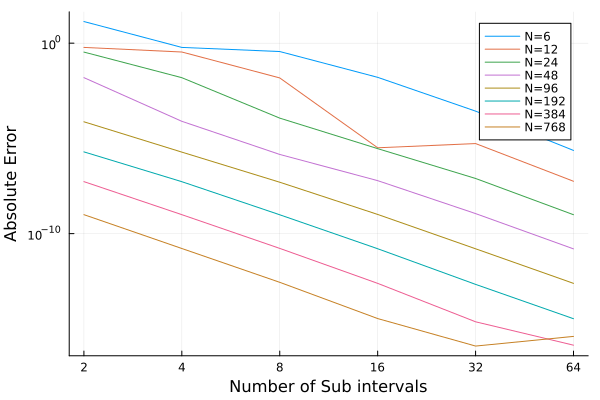

In [202]:
# Example 1: y'= - y .+ sin.(10*t), y(0)=1; T in [0, T]

using Plots

y0=1.0

lambda= 1

tspan=[0 15]


f(t, y)= - y .+ sin.(10*t)



# Exact Solution

exact = -(1/101)* exp(-tspan[2]) *(-111 +10*exp(tspan[2]) *cos(10*tspan[2])- exp(tspan[2]) *sin(10*tspan[2]))

p=8 # Parameter for various N values

q=6 # subinterval varying parameter

err1 = zeros(p, q)

nsub=zeros(q)

nval=zeros(p)

for n=1:p
    
    N= 6*2^(n-1)
    
    
    nval[n]= N # store N's
    
    for j= 1:q
        
        sub = 2^j # Number of subinterval
        
        nsub[j]= sub # store subinterval
    
        ds = tspan[2] / sub # final time / # of subinterval (I fixed here after Tuesday's meeting)

        y0= 1.0
        
        y=y0
        
        for i in 1:sub
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc_step(f, [t0 tf], y, N)

        end
        
        err1[n, j] = abs(exact - y)
        
    end
    
end


plot(nsub, err1[1, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(1 - 1))", ylabel="Absolute Error",xticks=nsub, xformatter=x -> string(Int(round(x))))
pdeg = polyfit(log10.(nsub[:]), log10.(err1[1,:]),1)
print(" N=$(6 * 2^(1 - 1)), p= ", abs(pdeg[2]),"\n")
for l in 2:p
    plot!(nsub, err1[l, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(l - 1))", xlabel="Number of Sub intervals", ylabel="Absolute Error", xticks=nsub, xformatter=x -> string(Int(round(x))))
    pdeg = polyfit(log10.(nsub[:]), log10.(err1[l,:]),1)
    print(" N=$(6 * 2^(l - 1)), p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

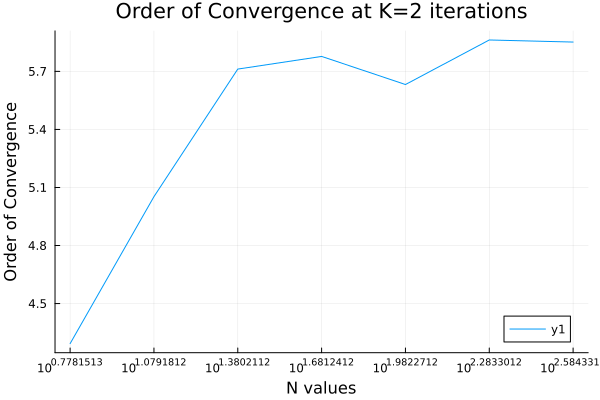

In [203]:
order1=zeros(p)
for i=1:p
    pdeg = polyfit(log10.(nsub[:]), log10.(err1[i,:]),1)
    order1[i]=abs(pdeg[2])
end
plot(nval[1:end-1], order1[1:end-1], xaxis=:log, xlabel="N values", ylabel="Order of Convergence", title="Order of Convergence at K=2 iterations", xticks=nval)

 N=6, p= 4.624345181297388
 N=12, p= 4.788252014494254
 N=24, p= 5.149559965281342
 N=48, p= 5.3100159512849565
 N=96, p= 5.727230680753948
 N=192, p= 4.498069883075081


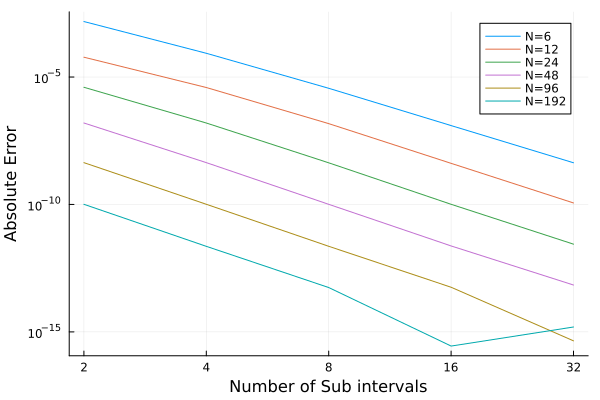

In [206]:
# Example : y'= , y(0)=1; T in [0, T]

using Plots

y0=1.0


tspan=[0 1]


f(t, y)= -2*pi .* cos.(t) .* y .^3



# Exact Solution

exact = 1/sqrt(1+4*pi*sin(tspan[2]))

p=6 # Parameter for various N values

q=5 # subinterval varying parameter

err = zeros(p, q)

nsub=zeros(q)

nval=zeros(p)

for n=1:p
    
    N= 6*2^(n-1)
    
    
    nval[n]= N # store N's
    
    for j= 1:q
        
        sub = 2^j # Number of subinterval
        
        nsub[j]= sub # store subinterval
    
        ds = tspan[2] / sub # final time / # of subinterval (I fixed here after Tuesday's meeting)

        y0= 1.0
        
        y=y0
        
        for i in 1:sub
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc_step(f, [t0 tf], y, N)

        end
        
        err[n, j] = abs(exact - y)
        
    end
    
end


plot(nsub, err[1, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(1 - 1))", ylabel="Absolute Error",xticks=nsub, xformatter=x -> string(Int(round(x))))
pdeg = polyfit(log10.(nsub[:]), log10.(err[1,:]),1)
print(" N=$(6 * 2^(1 - 1)), p= ", abs(pdeg[2]),"\n")
for l in 2:p
    plot!(nsub, err[l, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(l - 1))", xlabel="Number of Sub intervals", ylabel="Absolute Error", xticks=nsub, xformatter=x -> string(Int(round(x))))
    pdeg = polyfit(log10.(nsub[:]), log10.(err[l,:]),1)
    print(" N=$(6 * 2^(l - 1)), p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

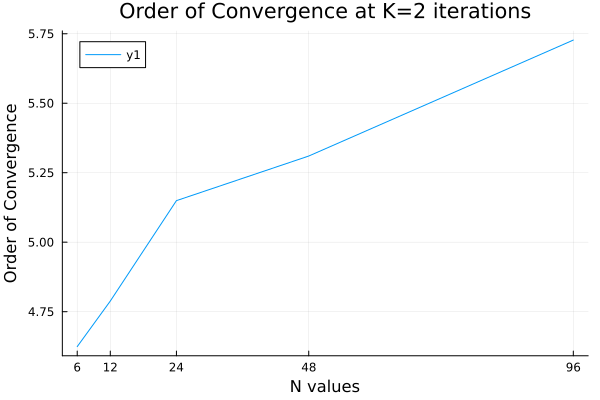

In [108]:
order=zeros(p)
for i=1:p
    pdeg = polyfit(log10.(nsub[:]), log10.(err[i,:]),1)
    order[i]=abs(pdeg[2])
end
plot(nval, order, xlabel="N values", ylabel="Order of Convergence", title="Order of Convergence at K=2 iterations", xticks=nval)

 N=6, p= 4.398231865171291
 N=12, p= 4.146787141050211
 N=24, p= 3.1851121301309866
 N=48, p= 1.7182215566171757


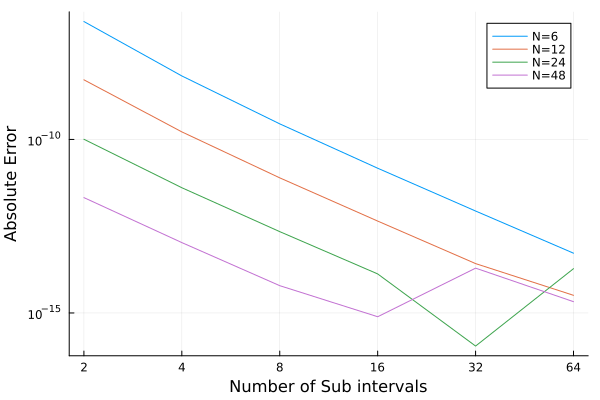

In [207]:
# Example : y'= , y(0)=1; T in [0, T]

using Plots

y0=1


tspan=[0 1]


f(t, y)= -sin.(t) .* y .^2 



# Exact Solution

exact = 1/(2-cos(tspan[2]))

p=5 # Parameter for various N values

q=6 # subinterval varying parameter

err4 = zeros(p, q)

nsub=zeros(q)

nval=zeros(p)

for n=1:p
    
    N= 6*2^(n-1)
    
    
    nval[n]= N # store N's
    
    for j= 1:q
        
        sub = 2^j # Number of subinterval
        
        nsub[j]= sub # store subinterval
    
        ds = tspan[2] / sub # final time / # of subinterval (I fixed here after Tuesday's meeting)

        
        y=y0
        
        for i in 1:sub
    
            t0 = (i - 1) * ds # initial time
            tf = i * ds   # final time
            
            y = ridc_step(f, [t0 tf], y, N)

        end
        
        err4[n, j] = abs(exact - y)
        
    end
    
end


plot(nsub, err4[1, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(1 - 1))", ylabel="Absolute Error",xticks=nsub, xformatter=x -> string(Int(round(x))))
pdeg = polyfit(log10.(nsub[:]), log10.(err4[1,:]),1)
print(" N=$(6 * 2^(1 - 1)), p= ", abs(pdeg[2]),"\n")
for l in 2:p-1
    plot!(nsub, err4[l, :], xaxis=:log, yaxis=:log,  label="N=$(6 * 2^(l - 1))", xlabel="Number of Sub intervals", ylabel="Absolute Error", xticks=nsub, xformatter=x -> string(Int(round(x))))
    pdeg = polyfit(log10.(nsub[:]), log10.(err4[l,:]),1)
    print(" N=$(6 * 2^(l - 1)), p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

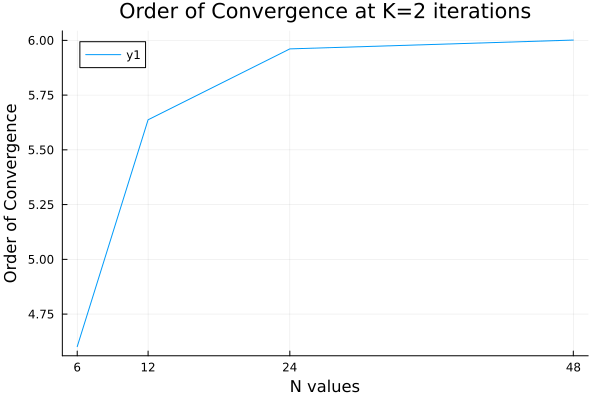

In [198]:
order4=zeros(p)
for i=1:p
    pdeg = polyfit(log10.(nsub[:]), log10.(err4[i,:]),1)
    order4[i]=abs(pdeg[2])
end
plot(nval[1:end-1], order4[1:end-1], xlabel="N values", ylabel="Order of Convergence", title="Order of Convergence at K=2 iterations", xticks=nval)

In [208]:
]add MultiFloats

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed SIMD ──────── v3.4.6
   Installed MultiFloats ─ v2.0.2
    Updating `~/.julia/environments/v1.7/Project.toml`
  [bdf0d083] + MultiFloats v2.0.2
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [bdf0d083] + MultiFloats v2.0.2
  [fdea26ae] + SIMD v3.4.6
Precompiling project...
  ✓ SIMD
  ✓ MultiFloats
  2 dependencies successfully precompiled in 4 seconds (418 already precompiled)


In [210]:
using MultiFloats
x=Float64x2(2.0)

2.0

In [211]:
y=sqrt(x)

1.414213562373095048801688724209694